# Bayesian linear regression using copula decomposition

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax.scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [3]:
def c(u, R):
    """
    Gaussian copula density
    """
    I = jnp.eye(len(R))
    v = norm.cdf(u)
    S = jnp.linalg.inv(R) - I
    density = jnp.einsum("i,ij,j->", v, S, v)
    density = jnp.exp(-density / 2)  / jnp.sqrt(jnp.linalg.det(R))
    return density

In [4]:
key = jax.random.PRNGKey(314)

In [5]:
weights = jnp.array([1.0, 0.3, -0.4]) # 'learned' weights

In [6]:
# building ground truth (known) correlation matrix
sigma = 1.0
corr = jnp.exp(-jnp.power(weights[:, None] - weights[None, :], 2) / (2 * sigma ** 2))
corr

Array([[1.        , 0.78270197, 0.3753106 ],
       [0.78270197, 1.        , 0.7827019 ],
       [0.3753106 , 0.7827019 , 1.        ]], dtype=float32)

In [7]:
# From correlation matrix to covariance matrix
variances = jnp.array([0.5, 1.1, 0.8])
stdevs = jnp.sqrt(variances)
# ground truth
cov = jnp.einsum("ij,i,j->ij", corr, stdevs, stdevs)
cov

Array([[0.49999997, 0.5804672 , 0.23736729],
       [0.5804672 , 1.0999997 , 0.7342394 ],
       [0.23736727, 0.7342394 , 0.8000001 ]], dtype=float32)

In [13]:
### Sample from independent gaussians
n_samples = 1000
params_samples = jax.random.normal(key, shape=(n_samples, 3))
params_samples = params_samples * variances[None, :]

params_samples.std(axis=0)

Array([0.51521945, 1.0914726 , 0.81173635], dtype=float32)

In [14]:
# test point
x = jnp.array([1.0, 0.2, -0.2])

In [15]:
# density evaluation of the copula
c_samples = jax.vmap(c, in_axes=(0, None))(params_samples, corr)

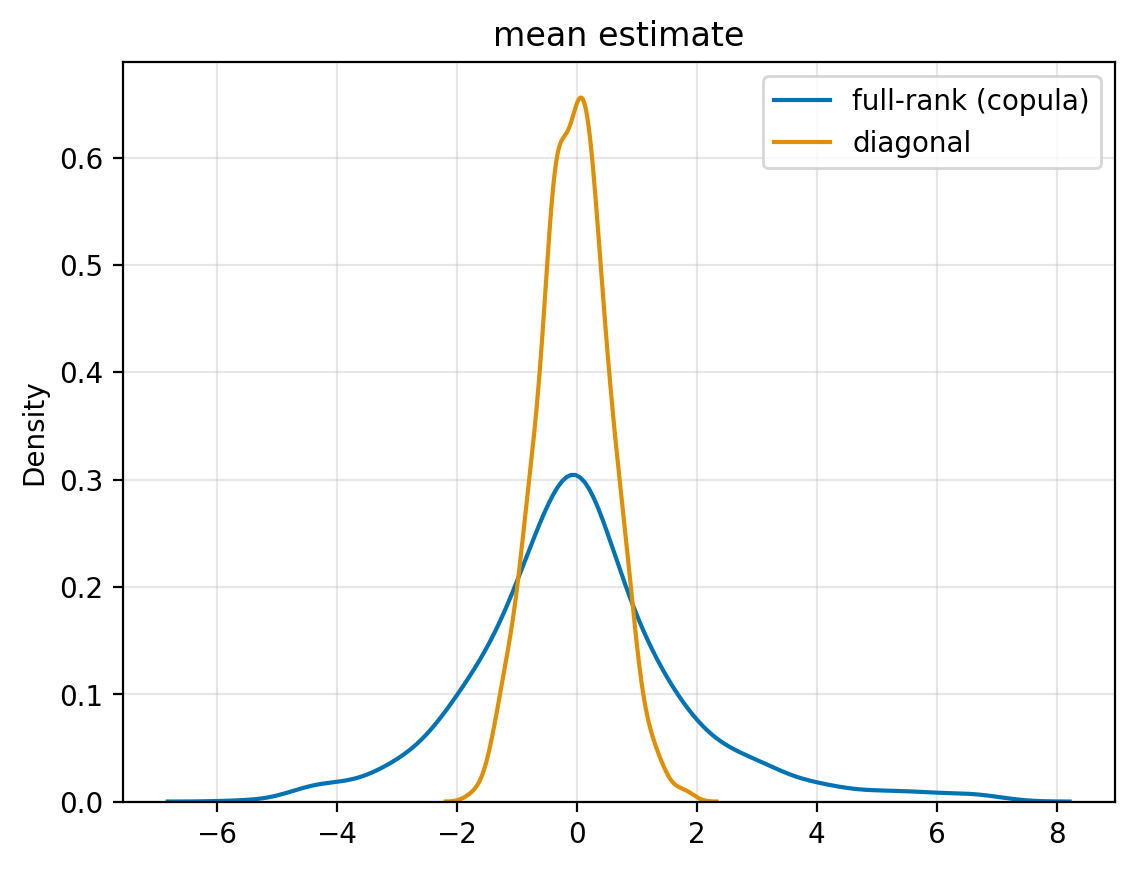

In [18]:
sns.kdeplot(((params_samples @ x) * c_samples), label="full-rank (copula)")
sns.kdeplot(((params_samples @ x)), label="diagonal")
plt.title("mean estimate")
plt.legend()
plt.grid(alpha=0.3)

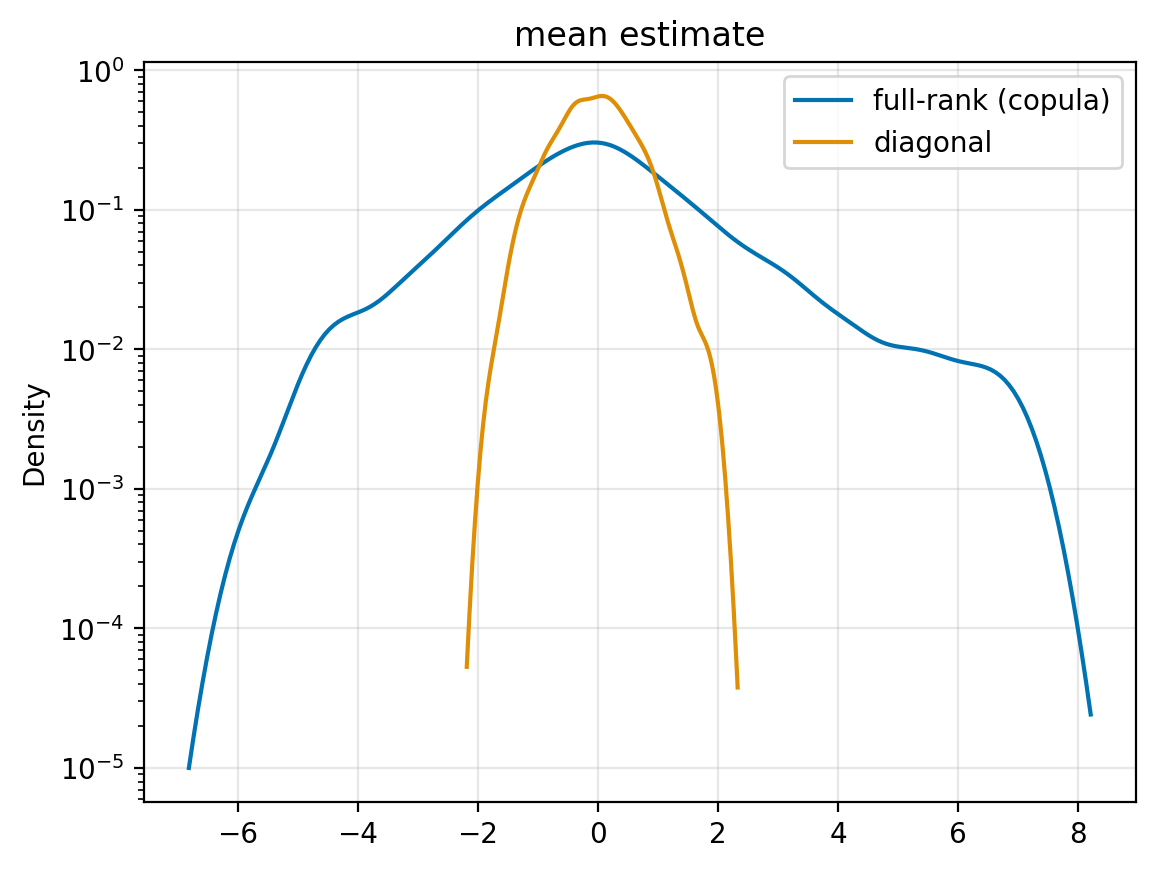

In [19]:
sns.kdeplot(((params_samples @ x) * c_samples), label="full-rank (copula)")
sns.kdeplot(((params_samples @ x)), label="diagonal")
plt.title("mean estimate")
plt.legend()
plt.yscale("log")
plt.grid(alpha=0.3)